In [379]:
import pandas as pd
import numpy as np
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
import rasterio
import glob
import xarray as xr
import matplotlib.pyplot as plt
import h5py
from scipy.signal import detrend
from sklearn.decomposition import TruncatedSVD
import os
import geopandas as gpd
import regionmask
from scipy.stats import zscore
import itertools
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nclcmaps

In [380]:
filepath = "data/scPDSI.cru_ts4.06early1.1901.2021.cal_1950_21.bams.2022.GLOBAL.IGBP.WHC.1901.2021.nc"
scpdsi_nc = xr.open_dataset(filepath).sel(time = slice("1982","2016")).scpdsi.rename({"latitude":"lat","longitude":"lon"}).groupby("time.year").mean("time")

In [381]:
ds = scpdsi_nc = xr.open_dataset(filepath).sel(time = slice("1982","2016")).scpdsi.rename({"latitude":"lat","longitude":"lon"})
continent_scpdsi = {}
for i in [0,1,2,3,5,7]:
    continents = gpd.read_file('world_continent.shp').iloc[[i]]
    polymask = regionmask.Regions(list(continents.explode().geometry))
    continent_ds = polymask.mask(ds)
    continent_ds = ds.where(np.isfinite(continent_ds))
    continent_scpdsi[continents.CONTINENT.values[0]] = continent_ds


continent_scpdsi['Africa_Below_Equator'] = continent_scpdsi['Africa'].where(continent_scpdsi['Africa'].lat < 0)
continent_scpdsi['Africa_Above_Equator'] = continent_scpdsi['Africa'].where(continent_scpdsi['Africa'].lat > 0)

# drop africa
continent_scpdsi.pop('Africa')
continent_scpdsi.keys()

dict_keys(['Asia', 'Australia', 'North America', 'South America', 'Europe', 'Africa_Below_Equator', 'Africa_Above_Equator'])

In [234]:
import xarray as xr
import numpy as np

growing_months = {
    "rice": {
        "Asia": [5, 6, 7, 8, 9, 10],  # May to October
        "Africa_Above_Equator": [5, 6, 7, 8, 9, 10],  # May to October
        "Africa_Below_Equator": [11, 12, 1, 2, 3, 4],  # November to April
        "North America": [4, 5, 6, 7, 8, 9],  # April to September
        "South America": [11, 12, 1, 2, 3],  # November to March
        "Europe": [5, 6, 7, 8, 9],  # May to September
        "Australia": [10, 11, 12, 1, 2, 3, 4]  # October to April
    },
    "soy": {
        "Asia": [6, 7, 8, 9, 10, 11],  # June to November
        "Africa_Above_Equator": [6, 7, 8, 9, 10],  # June to October
        "Africa_Below_Equator": [11, 12, 1, 2, 3],  # November to March
        "North America": [5, 6, 7, 8, 9],  # May to September
        "South America": [10, 11, 12, 1, 2, 3, 4, 5, 6],  # October to June
        "Europe": [5, 6, 7, 8, 9],  # May to September
        "Australia": [10, 11, 12, 1, 2, 3, 4]  # October to April
    },
    "maize": {
        "Asia": [6, 7, 8, 9, 10],  # June to October
        "Africa_Above_Equator": [4, 5, 6, 7, 8, 9],  # April to September
        "Africa_Below_Equator": [11, 12, 1, 2, 3],  # November to March
        "North America": [4, 5, 6, 7, 8, 9],  # April to September
        "South America": [10, 11, 12, 1, 2, 3, 4, 5],  # October to May
        "Europe": [4, 5, 6, 7, 8, 9, 10],  # April to October
        "Australia": [10, 11, 12, 1, 2, 3, 4]  # October to April
    },
    "wheat": {
        "Asia": [10, 11, 12, 1, 2, 3, 4],  # October to April
        "Africa_Above_Equator": [11, 12, 1, 2, 3],  # November to March
        "Africa_Below_Equator": [5, 6, 7, 8, 9, 10],  # May to October
        "North America": [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7],  # September to July
        "South America": [5, 6, 7, 8, 9, 10, 11, 12],  # May to December
        "Europe": [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8],  # October to August
        "Australia": [5, 6, 7, 8, 9, 10, 11]  # May to November
    }
}


def calculate_prob_and_count_xr(xr_x, xr_y, x_threshold=-2, y_threshold_offset=1):
    """
    Calculate the probability and count for each grid point in xr_x and xr_y.
    
    Parameters:
    - xr_x: xarray.DataArray for x values (time, lat, lon).
    - xr_y: xarray.DataArray for y values (time, lat, lon).
    - x_threshold: Threshold for x values (default is -2).
    - y_threshold_offset: Multiplier for std deviation offset from the mean (default is 1).
    
    Returns:
    - xarray.DataArray with dimensions (lat, lon) containing 'probability' and 'count'.
    """

    # Calculate mean and standard deviation for y along the time axis
    y_mean = xr_y.mean(dim='time')
    y_std = xr_y.std(dim='time')
    
    # Set threshold for y as mean - (std * offset)
    y_threshold = y_mean - (y_std * y_threshold_offset)
    
    # Create masks for x and y based on the thresholds
    x_mask = xr_x < x_threshold  # Mask for x where x < x_threshold
    y_mask = xr_y < y_threshold  # Mask for y where y < y_threshold
    
    # Calculate the total count where x < x_threshold for each grid point (lat, lon)
    total_count_x = x_mask.sum(dim='time')
    
    # Calculate the count where both x < x_threshold and y < y_threshold for each grid point
    count_condition_met = (x_mask & y_mask).sum(dim='time')
    
    # Avoid division by zero: if total_count_x is zero, return NaN for probability
    probability = xr.where(total_count_x > 0, count_condition_met / total_count_x, np.nan)
    
    # Create a DataArray for the output with 'count' and 'probability' as variables
    results = xr.Dataset({
        'count': count_condition_met,
        'probability': probability
    })
    
    return results

In [239]:
def scpdsi_crop_annual(growing_months,crop="rice", continent_scpdsi=continent_scpdsi):
    dict_out = {}
    for continent in continent_scpdsi.keys():
        dict_out[continent] = continent_scpdsi[continent].sel(time=continent_scpdsi[continent].time.dt.month.isin(growing_months[crop][continent])).groupby("time.year").mean("time").rename({"year":"time"})
    return dict_out

rice_scpdsi = scpdsi_crop_annual(growing_months,crop="rice")
soy_scpdsi = scpdsi_crop_annual(growing_months,crop="soy")
maize_scpdsi = scpdsi_crop_annual(growing_months,crop="maize")
wheat_scpdsi = scpdsi_crop_annual(growing_months,crop="wheat")


In [243]:
scpdsi_nc_2= scpdsi_nc.rename({"year":"time"})

In [282]:
wheat = "wheat_1981_2016.nc"
soy = "soy_1981_2016.nc"
maize = "maize_1981_2016.nc"
rice = "rice_1981_2016.nc"



def read_netcdf(filepath):
    data = xr.open_dataset(filepath)['var']
    data.coords['lon'] = (data.coords['lon'] + 180) % 360 - 180
    data = data.sortby(data.lon)
    data = data.sortby(data.lat, ascending=False)
    data = data.diff('time')
    data.coords['time'] = scpdsi_nc_2.time
    return data

wheat = read_netcdf(wheat)
soy = read_netcdf(soy)
maize = read_netcdf(maize)
rice = read_netcdf(rice)

In [400]:
rice_prob = {}
wheat_prob = {}
soy_prob = {}
maize_prob = {}

for continent in rice_scpdsi.keys():
    rice_prob[continent] = calculate_prob_and_count_xr(rice_scpdsi[continent],rice,x_threshold=-2, y_threshold_offset=0.5)
    wheat_prob[continent] = calculate_prob_and_count_xr(wheat_scpdsi[continent],wheat,x_threshold=-2, y_threshold_offset=0.5)
    soy_prob[continent] = calculate_prob_and_count_xr(soy_scpdsi[continent],soy,x_threshold=-2, y_threshold_offset=0.5)
    maize_prob[continent] = calculate_prob_and_count_xr(maize_scpdsi[continent],maize,x_threshold=-2, y_threshold_offset=0.5)
    

In [401]:
# makezero prob as nan
for continent in rice_prob.keys():
    rice_prob[continent] = rice_prob[continent].where(rice_prob[continent].probability > 0)
    wheat_prob[continent] = wheat_prob[continent].where(wheat_prob[continent].probability > 0)
    soy_prob[continent] = soy_prob[continent].where(soy_prob[continent].probability > 0)
    maize_prob[continent] = maize_prob[continent].where(maize_prob[continent].probability > 0)
    
    
    

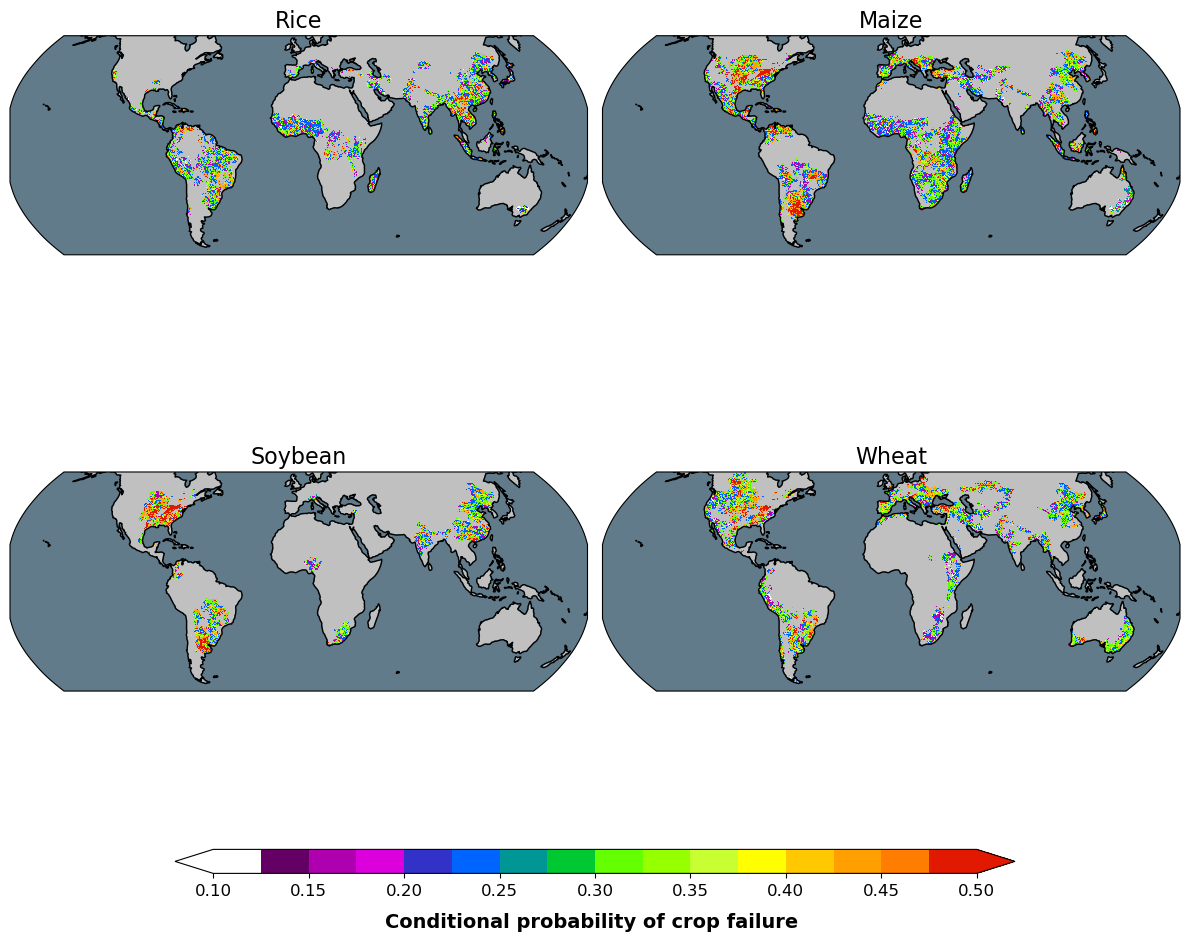

In [402]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Define the continent keys for probability data to iterate over
continents = ['Africa_Above_Equator', 'Africa_Below_Equator', 'Asia', 
              'Europe', 'North America', 'South America', 'Australia']

# Example probability datasets for each crop (replace with actual data)
crops_prob = {
    'Rice': rice_prob,
    'Maize': maize_prob,
    'Soybean': soy_prob,
    'Wheat': wheat_prob
}

# Set up figure and subplots (2x2 for four crops)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), subplot_kw={'projection': ccrs.Robinson()})
axs = axs.flatten()  # Flattening to easily loop through axes

# Set color limits and colormap
vmin, vmax = 0.1,0.6
cmap = nclcmaps.cmap('precip2_15lev')  # You can choose any other colormap
norm = Normalize(vmin=vmin, vmax=vmax)

# Loop through crops and plot for each
for i, (crop, crop_prob) in enumerate(crops_prob.items()):
    ax = axs[i]
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='silver')
    ax.add_feature(cfeature.OCEAN,color ='#627b8a')
    ax.set_extent([-180, 180, -60, 60], crs=ccrs.PlateCarree())
    
    # Loop over continents and plot probability data
    for continent in continents:
        crop_prob[continent].probability.plot(
            ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False,robust = True,
            levels = [0.1,0.2,0.3,0.4,0.5,0.6]
        )
    
    # Set the title for each subplot to the crop name
    ax.set_title(f'{crop}', fontsize=16)

# Add a common colorbar for all subplots
    
# fig.subplots_adjust(bottom=0.5, top=0.99, left=0.5, right=0.95)  # Adjust the subplot layout
fig.subplots_adjust(wspace= -0.05, hspace=0.01)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # Position of the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.1, vmax=0.5))
cbar = fig.colorbar(sm, cax=cbar_ax,extend = 'both', orientation='horizontal')
cbar.set_label("Conditional probability of crop failure ", size=14, color='k', fontweight='bold',labelpad =10)
cbar.ax.tick_params(labelsize=12)  # Set the colorbar tick labels font size
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plot
plt.show()


In [403]:
# Calculate the mean probability of crop failure for each continent
continent_wise_mean = {}

for crop in crops_prob.keys():
    continent_wise_mean[crop] = {}
    for continent in continents:
        continent_wise_mean[crop][continent] = crops_prob[crop][continent].probability.mean().values
       
        

In [399]:
pd.DataFrame(continent_wise_mean).T

,Africa_Above_Equator,Africa_Below_Equator,Asia,Europe,North America,South America,Australia
Rice,0.18748207588400126,0.2306109484642586,0.2169477147958258,0.19338664195973448,0.2609633366211869,0.21612947196405446,0.16786643146685962
Maize,0.18053058019448442,0.2166771179176494,0.22006780745863147,0.2615915106905881,0.30971454147741917,0.3089486879351778,0.14004492801825721
Soybean,0.17049012495441068,0.2117352712233634,0.22887707468867854,0.26062552939151407,0.38729374088776886,0.3062475179688532,nan
Wheat,0.16558885479376928,0.15201012936832717,0.22275018325670648,0.25829343745496075,0.27104595542581633,0.25984734144160754,0.2437918563547544
